In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime as dt
import jdatetime as jd
from loguru import logger

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
#np.random.seed(0)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')

In [113]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0)

## EDA

In [242]:
# def summary(df):
#     display(df.describe())
#     pass

keys = ['dtype','pct_of_nan', 'num_uniques']+list(revenue.describe().T.columns)[:-1]
logger.info(f'Data shape: {revenue.shape}')
pd.concat([revenue.dtypes, 
          (revenue.isna().sum() / revenue.shape[0] * 100).map('% {:,.2f}'.format),
          revenue.nunique(),
          revenue.describe().T], axis=1, keys=keys)

2022-04-10 00:44:08.452 | INFO     | __main__:<cell line: 6>:6 - Data shape: (261960, 8)


dtype pct_of_nan num_uniques  count                            \
                 0          1           2  count     mean     std      min   
CustomerID   int64     % 0.00      179680 261960  7169337 4957141   465132   
OrderID      int64     % 0.00      261960 261960 45264897 6121027 32930756   
Date         int64     % 0.00         396 261960 20193661    4238 20190321   
Revenue      int64     % 0.00        3314 261960     6110    5647      106   
JdDate      object     % 0.00         396    NaN      NaN     NaN      NaN   
GDate       object     % 0.00         396    NaN      NaN     NaN      NaN   
JdMonth     object     % 0.00          12    NaN      NaN     NaN      NaN   
JdWeekday   object     % 0.00           7    NaN      NaN     NaN      NaN   

                                                
                25%      50%      75%      max  
CustomerID  3267469  6663396 11227062 46549548  
OrderID    40061748 44792436 50045929 58853188  
Date       20190821 20191109 20200115 20200419  
Revenue        2451     5100     7960   175200  
JdDate          NaN      NaN      NaN      NaN  
GDate           NaN      NaN      NaN      NaN  
JdMonth         NaN      NaN      NaN      NaN  
JdWeekday       NaN      NaN      NaN      NaN

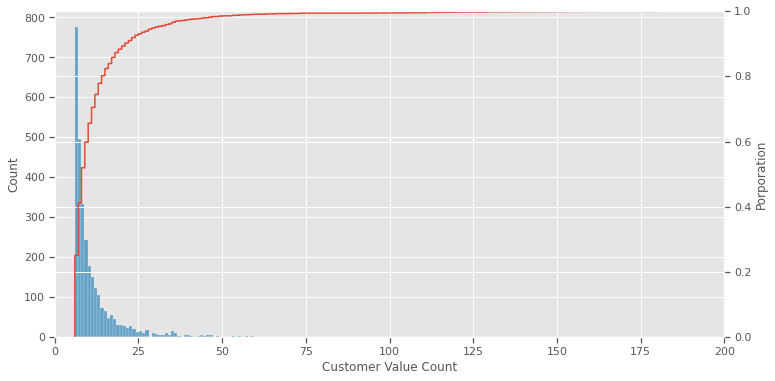

In [243]:
fig, ax1 = plt.subplots()
# ax1.set_title('Average Percipitation Percentage by Month')
ax1.set_xlabel('Customer Value Count')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,200)
ax2.set_xlim(0,200)
plt.show()

In [70]:
jd.set_locale('fa_IR')

'fa_IR'

In [7]:
for index, row in revenue.iterrows():
    assert len(str(row['Date'])) == 8


### Date feature is surely in need for parsing
both to Jalali datetime and Gregory datetime

In [118]:
for index, row in revenue.iterrows():
    revenue.loc[index, 'JdDate'] = jd.date.fromgregorian(date=dt.datetime.strptime(str(row['Date']), '%Y%m%d'))
    revenue.loc[index, 'GDate'] = dt.datetime.strptime(str(row['Date']), '%Y%m%d')

for index, row in revenue.iterrows():
    revenue.loc[index, 'JdMonth'] = jd.datetime.jmonth_short(row['JdDate'])
    revenue.loc[index, 'JdWeekday'] = jd.datetime.jweekday_short(row['JdDate'])
    revenue.loc[index, 'GDate'] = dt.datetime.date(row['GDate'])

In [50]:
logger.info(f'last Gregory Date = {revenue.GDate.max()}, \n last Jalali date = {str(revenue.JdDate.max())}')

2022-04-09 22:32:16.120 | INFO     | __main__:<cell line: 1>:1 - last Gregory Date = 2020-04-19, 
 last Jalali date = 1399-01-31


let's see if we can see the disturbution of Revenue

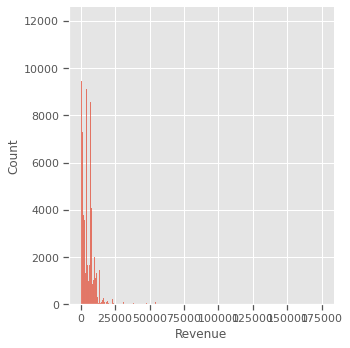

In [15]:
g = sns.displot(revenue.Revenue)

most of our variable almosst follow the pareto dist, huh! intresting.


## task 1
1. Average Order Value, Average Frequency, total revenue in each month of 1398. (Based on Persian calendar)

In [25]:
avg_order_val = np.mean(revenue.groupby('OrderID')['Revenue'].mean()) #Average Order Value
avg_freq = np.mean(revenue.groupby('CustomerID')['OrderID'].count()) #Average Frequency

logger.info(f'\n Average Order Value = {avg_order_val} \n Average Frequency {avg_freq}')

2022-04-09 22:15:15.100 | INFO     | __main__:<cell line: 4>:4 - 
 Average Order Value = 6109.57059474729 
 Average Frequency 1.4579252003561889


In [153]:
revehnue1398 = revenue[revenue['JdDate']< jd.date(1399, 1, 1)]
logger.info('\n AVG Revenue Per Month in 1388')
summary98 = pd.concat([revehnue1398.groupby(pd.Grouper(key="JdMonth")).agg({'Revenue': 'mean','OrderID': 'count'})\
            .rename(columns={'Revenue': 'AVG Revenue Per Month' ,'OrderID': 'Count Order Per Month'}),
revehnue1398.groupby(pd.Grouper(key="JdMonth")).agg({'Revenue': 'sum'}).rename(columns={'Revenue': 'Total Revenue Per Month'})], axis=1)

summary98

2022-04-09 23:35:13.019 | INFO     | __main__:<cell line: 2>:2 - 
 AVG Revenue Per Month in 1388


,AVG Revenue Per Month,Count Order Per Month,Total Revenue Per Month
JdMonth,,,
Far,5983,3279,19618499
Ord,6811,3503,23860379
Kho,6354,14380,91363493
Tir,6615,16228,107350424
Mor,5111,28663,146502637
Sha,5603,18630,104375481
Meh,5642,26699,150623504
Aba,5507,33233,183010916
Aza,5821,30989,180390183


In [189]:
# style.applymap(lambda v:'color:red;' if v is True, props='color:red;')\
# .applymap(lambda v:'color:red;' if v is True else None)

summary98[summary98==summary98.max()]


,AVG Revenue Per Month,Count Order Per Month,Total Revenue Per Month
JdMonth,,,
Far,NaN,NaN,NaN
Ord,NaN,NaN,NaN
Kho,NaN,NaN,NaN
Tir,NaN,NaN,NaN
Mor,NaN,NaN,NaN
Sha,NaN,NaN,NaN
Meh,NaN,NaN,NaN
Aba,NaN,33233,183010916
Aza,NaN,NaN,NaN


In [197]:
rev_agg = revenue.groupby("GDate").Revenue.sum().reset_index()

<AxesSubplot:xlabel='GDate', ylabel='Revenue'>

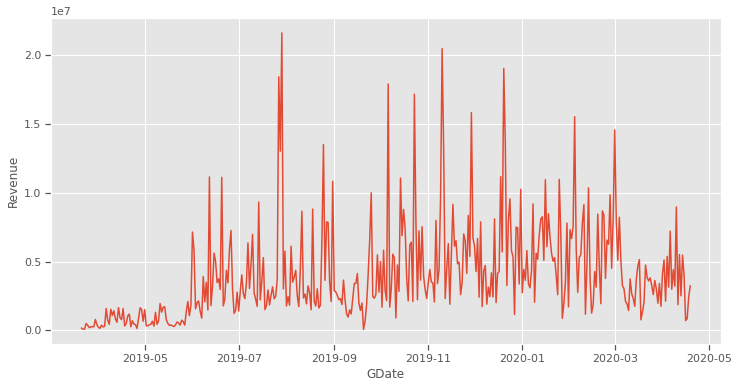

In [201]:
sns.lineplot(x=rev_agg.GDate, y=rev_agg.Revenue, estimator='mean')

In [209]:
LASTGDATE = revenue.GDate.max()
LASTJDATE = revenue.JdDate.max()

let's creat Recency, Frequency, Monitize(both on avg and total)

In [208]:
recency = revenue.groupby(['CustomerID'],as_index=False)['JdDate'].max()\
                 .rename(columns={'JdDate': 'LastPurchaseDate'})


In [211]:
recency['Recency'] = recency.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)

<AxesSubplot:xlabel='Recency', ylabel='Count'>

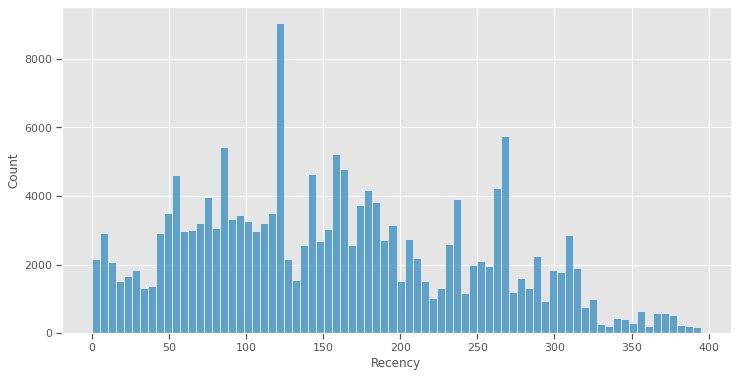

In [215]:
sns.histplot(recency.Recency)

In [222]:
freq_mon = revenue.groupby('CustomerID', as_index=False)\
                  .agg({'OrderID': 'count',
                        'Revenue': 'sum'})\
                  .rename(columns={'OrderID' :'Frequency',
                           'Revenue':'Monetary'})

<AxesSubplot:xlabel='Frequency', ylabel='count'>

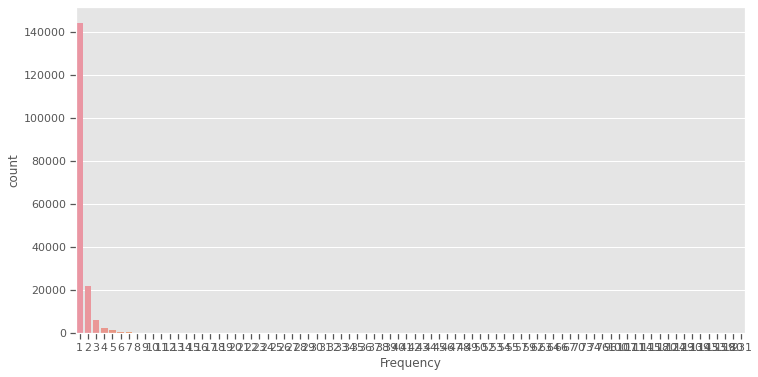

In [236]:
sns.countplot(freq_mon.Frequency)


pareto again :)

<AxesSubplot:xlabel='Monetary'>

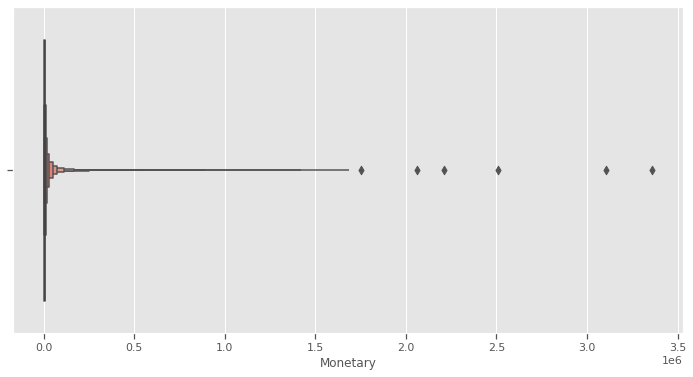

In [239]:
sns.boxenplot(freq_mon.Monetary)

In [245]:
rfm_df = recency.merge(freq_mon,on='CustomerID').drop(columns='LastPurchaseDate')

In [250]:
keys = ['dtype', 'num_uniques']+list(rfm_df.describe().T.columns)
logger.info(f'Data shape: {rfm_df.shape}')
pd.concat([rfm_df.dtypes, 
          rfm_df.nunique(),
          rfm_df.describe().T], axis=1, keys=keys)

2022-04-10 00:47:16.853 | INFO     | __main__:<cell line: 2>:2 - Data shape: (179680, 4)


dtype num_uniques  count                                         \
                0           1  count    mean     std    min     25%     50%   
CustomerID  int64      179680 179680 7606196 5001455 465132 3536368 7100330   
Recency     int64         396 179680     158      90      0      85     150   
Frequency   int64          82 179680       1       2      1       1       1   
Monetary    int64       16962 179680    8907   25864    106    2899    5467   

                              
                75%      max  
CustomerID 11658242 46549548  
Recency         232      395  
Frequency         1      231  
Monetary       9754  3360683

## Clustering